In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from collections import Counter

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [2]:
# class_names_map = {
#     0: "Accident",
#     1: "Sexual Harassment",
#     2: "Blood",
#     3: "Blood and Gore",
#     4: "Explosion",
#     5: "Violence",
#     6: "nudity",
#     7: "Suicide"
# }

# def convert_yolo_to_classification(yolo_folder, output_folder):
#     image_folder = os.path.join(yolo_folder, "images")
#     label_folder = os.path.join(yolo_folder, "labels")
#     for label_file in os.listdir(label_folder):
#         label_path = os.path.join(label_folder, label_file)
#         with open(label_path, "r") as f:
#             first_line = f.readline().strip()
#             if not first_line:
#                 continue
#             class_id = int(first_line.split()[0])
#             class_name = class_names_map[class_id]
#         class_dir = os.path.join(output_folder, class_name)
#         os.makedirs(class_dir, exist_ok=True)
#         img_file = label_file.replace(".txt", ".jpg")
#         src_img_path = os.path.join(image_folder, img_file)
#         dst_img_path = os.path.join(class_dir, img_file)
#         if os.path.exists(src_img_path):
#             shutil.copy(src_img_path, dst_img_path)

In [3]:
# convert_yolo_to_classification("dataset/train", "converted/train")
# convert_yolo_to_classification("dataset/valid", "converted/valid")
# convert_yolo_to_classification("dataset/test", "converted/test")

In [ ]:
# def undersample_folder(folder_path, max_samples=400):
#     nudity_dir = os.path.join(folder_path, "nudity")
#     if not os.path.exists(nudity_dir):
#         print(f"Folder {nudity_dir} tidak ditemukan.")
#         return
#     files = [f for f in os.listdir(nudity_dir) if os.path.isfile(os.path.join(nudity_dir, f))]
#     if len(files) <= max_samples:
#         print(f"Jumlah file nudity di {folder_path} sudah <= {max_samples}")
#         return
#     # Acak dan pilih file yang akan DIHAPUS
#     files_to_remove = random.sample(files, len(files) - max_samples)
#     for f in files_to_remove:
#         os.remove(os.path.join(nudity_dir, f))
#     print(f"Berhasil mengurangi file nudity di {folder_path} menjadi {max_samples}")

# # Jalankan untuk train, valid, dan test
# undersample_folder('converted/train', max_samples=400)
# undersample_folder('converted/valid', max_samples=100)
# undersample_folder('converted/test', max_samples=50)

In [ ]:
# def oversample_minority_classes(parent_dir, target_count=400):
#     for class_name in os.listdir(parent_dir):
#         class_dir = os.path.join(parent_dir, class_name)
#         if not os.path.isdir(class_dir):
#             continue
#         files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
#         n_files = len(files)
#         if n_files >= target_count:
#             continue  # Sudah cukup
#         print(f"Oversampling {class_name}: {n_files} -> {target_count}")
#         while len(files) < target_count:
#             file_to_copy = random.choice(files)
#             src = os.path.join(class_dir, file_to_copy)
#             # Buat nama file baru agar tidak overwrite
#             new_name = f"dup_{len(files)}_{file_to_copy}"
#             dst = os.path.join(class_dir, new_name)
#             shutil.copy(src, dst)
#             files.append(new_name)

# # Jalankan untuk train, valid, dan test
# oversample_minority_classes('converted/train', target_count=400)
# oversample_minority_classes('converted/valid', target_count=100)
# oversample_minority_classes('converted/test', target_count=50)

In [ ]:
train_dir = 'converted/train'
val_dir = 'converted/valid'
test_dir = 'converted/test'
img_size = (224, 224)
batch_size = 32
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)


Classes: ['Accident', 'Blood', 'Blood and Gore', 'Explosion', 'Normal', 'Sexual Harassment', 'Suicide', 'Violence', 'nudity']


In [ ]:
def calculate_custom_class_weights(y_train, alpha=0.5):
    """
    Calculate custom class weights with higher penalty for majority class
    alpha: parameter to control the severity of penalty (0.1-1.0)
    """
    class_counts = Counter(y_train)
    total_samples = len(y_train)
    
    weights = {}
    for class_idx, count in class_counts.items():
        # Standard balanced weight
        standard_weight = total_samples / (num_classes * count)
        # Apply additional penalty for majority class
        if count > total_samples * 0.4:  # If class > 40% of dataset
            penalty_weight = standard_weight * (1 + alpha * (count / total_samples))
            weights[class_idx] = 1.0 / penalty_weight  # Invert for penalty
        else:
            weights[class_idx] = standard_weight
    
    return weights

In [6]:
def create_simple_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    val_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator

In [7]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss untuk menangani class imbalance
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Calculate cross entropy
        ce = -y_true * tf.math.log(y_pred)
        
        # Calculate weights
        weights = alpha * y_true * tf.pow((1 - y_pred), gamma)
        
        # Apply focal loss
        focal_loss = weights * ce
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
    
    return focal_loss_fixed

In [8]:
def create_simple_model():
    model = tf.keras.Sequential([
        layers.Input(shape=img_size + (3,)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [10]:
# Gunakan generator dan model sederhana
train_generator, val_generator = create_simple_generators()
model = create_simple_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
print(class_names)
print(val_generator.class_indices)
import numpy as np
print(np.bincount(val_generator.classes))


Found 3600 images belonging to 9 classes.
Found 919 images belonging to 9 classes.
['Accident', 'Blood', 'Blood and Gore', 'Explosion', 'Normal', 'Sexual Harassment', 'Suicide', 'Violence', 'nudity']
{'Accident': 0, 'Blood': 1, 'Blood and Gore': 2, 'Explosion': 3, 'Normal': 4, 'Sexual Harassment': 5, 'Suicide': 6, 'Violence': 7, 'nudity': 8}
[100 100 100 100 100 119 100 100 100]


In [11]:
y_train = train_generator.classes
custom_class_weights = calculate_custom_class_weights(y_train, alpha=0.7)
print("Custom Class Weights:", custom_class_weights)


Custom Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0}


In [ ]:
# Tambahan impor callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# CALLBACK TAMBAHAN
class WarmUpLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, warmup_epochs, verbose=0):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_epochs = warmup_epochs
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
            # Perbaikan di bawah ini:
            import tensorflow as tf
            if hasattr(self.model.optimizer, 'lr') and isinstance(self.model.optimizer.lr, tf.Variable):
                self.model.optimizer.lr.assign(lr)
            elif hasattr(self.model.optimizer, 'learning_rate') and isinstance(self.model.optimizer.learning_rate, tf.Variable):
                self.model.optimizer.learning_rate.assign(lr)
            if self.verbose > 0:
                print(f"\nEpoch {epoch+1}: Warmup learning rate set to {lr:.6f}")

# CALLBACKS LENGKAP
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    WarmUpLearningRateScheduler(initial_lr=1e-5, warmup_epochs=5, verbose=1)
]


In [13]:

print("Start fine-tuning EfficientNet with low learning rate...")
history_finetune = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
)
x_val, y_val = next(val_generator)
y_pred = model.predict(x_val)
print("True:", np.argmax(y_val, axis=1))
print("Pred:", np.argmax(y_pred, axis=1))

Start fine-tuning EfficientNet with low learning rate...


d:\S8NRC\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: Warmup learning rate set to 0.000002
Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.4105 - loss: 2.7104 - precision: 0.5544 - recall: 0.1721
Epoch 1: val_loss improved from inf to 1.58834, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 618ms/step - accuracy: 0.4119 - loss: 2.7017 - precision: 0.5564 - recall: 0.1733 - val_accuracy: 0.5604 - val_loss: 1.5883 - val_precision: 0.5951 - val_recall: 0.3711 - learning_rate: 0.0010

Epoch 2: Warmup learning rate set to 0.000004
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.7788 - loss: 1.0677 - precision: 0.8829 - recall: 0.6263
Epoch 2: val_loss improved from 1.58834 to 1.51459, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 618ms/step - accuracy: 0.7788 - loss: 1.0676 - precision: 0.8829 - recall: 0.6264 - val_accuracy: 0.5789 - val_loss: 1.5146 - val_precision: 0.6432 - val_recall: 0.4766 - learning_rate: 0.0010

Epoch 3: Warmup learning rate set to 0.000006
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8395 - loss: 0.9217 - precision: 0.9181 - recall: 0.7170
Epoch 3: val_loss improved from 1.51459 to 1.28038, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 618ms/step - accuracy: 0.8396 - loss: 0.9216 - precision: 0.9181 - recall: 0.7171 - val_accuracy: 0.7073 - val_loss: 1.2804 - val_precision: 0.8217 - val_recall: 0.5267 - learning_rate: 0.0010

Epoch 4: Warmup learning rate set to 0.000008
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8766 - loss: 0.8595 - precision: 0.9353 - recall: 0.7776
Epoch 4: val_loss did not improve from 1.28038
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 625ms/step - accuracy: 0.8766 - loss: 0.8595 - precision: 0.9353 - recall: 0.7776 - val_accuracy: 0.6670 - val_loss: 1.5487 - val_precision: 0.7353 - val_recall: 0.5593 - learning_rate: 0.0010

Epoch 5: Warmup learning rate set to 0.000010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.8755 - loss: 0.8341 - precision: 0.9348 - recall: 0.7946
Epoch 5: val_loss did not improve from 1.28038
113/113 ━━━━━━━━━━━━━━━━━━━━ 74s 653ms/step - accuracy: 0.8756 - loss: 0.8339 - precision: 0.9349 - recall: 0.

In [14]:
# Fungsi visualisasi training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()


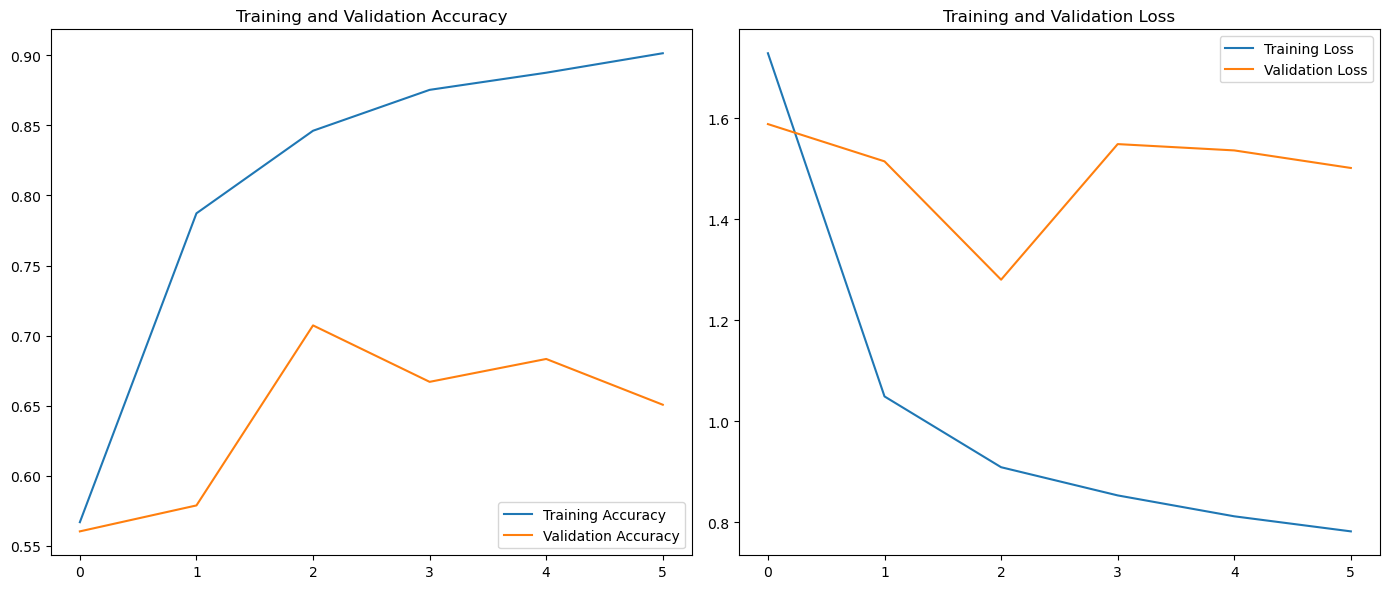

In [15]:
plot_training_history(history_finetune)

In [16]:
def advanced_evaluation(model, test_generator):
    # Predictions
    test_generator.reset()
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Normalized Confusion Matrix
    cm_normalized = confusion_matrix(y_true, y_pred_classes, normalize='true')
    
    # Plot both confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Raw confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp1.plot(ax=ax1, cmap='Blues')
    ax1.set_title("Raw Confusion Matrix")
    
    # Normalized confusion matrix
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    disp2.plot(ax=ax2, cmap='Blues')
    ax2.set_title("Normalized Confusion Matrix")
    
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy analysis
    print("\nPer-class Analysis:")
    for i, class_name in enumerate(class_names):
        class_mask = (y_true == i)
        if np.sum(class_mask) > 0:
            class_accuracy = np.sum((y_pred_classes == i) & class_mask) / np.sum(class_mask)
            print(f"{class_name}: {class_accuracy:.3f} accuracy ({np.sum(class_mask)} samples)")



In [17]:
# Test the improved model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 459 images belonging to 9 classes.


459/459 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6455 - loss: 1.4908 - precision: 0.8230 - recall: 0.3820

Test Results:
Accuracy: 0.5861
Precision: 0.7462
Recall: 0.4292
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

Detailed Classification Report:
                   precision    recall  f1-score   support

         Accident       0.67      0.86      0.75        50
            Blood       0.63      1.00      0.78        50
   Blood and Gore       0.57      0.16      0.25        50
        Explosion       1.00      0.10      0.18        50
           Normal       0.44      0.28      0.34        50
Sexual Harassment       0.42      0.61      0.50        59
          Suicide       0.83      0.78      0.80        50
         Violence       0.46      0.64      0.53        50
           nudity       0.68      0.84      0.75        50

         accuracy                           0.59       459
        macro avg       0.63      0.59      0.54       459
     weighted avg       0.63      0.59

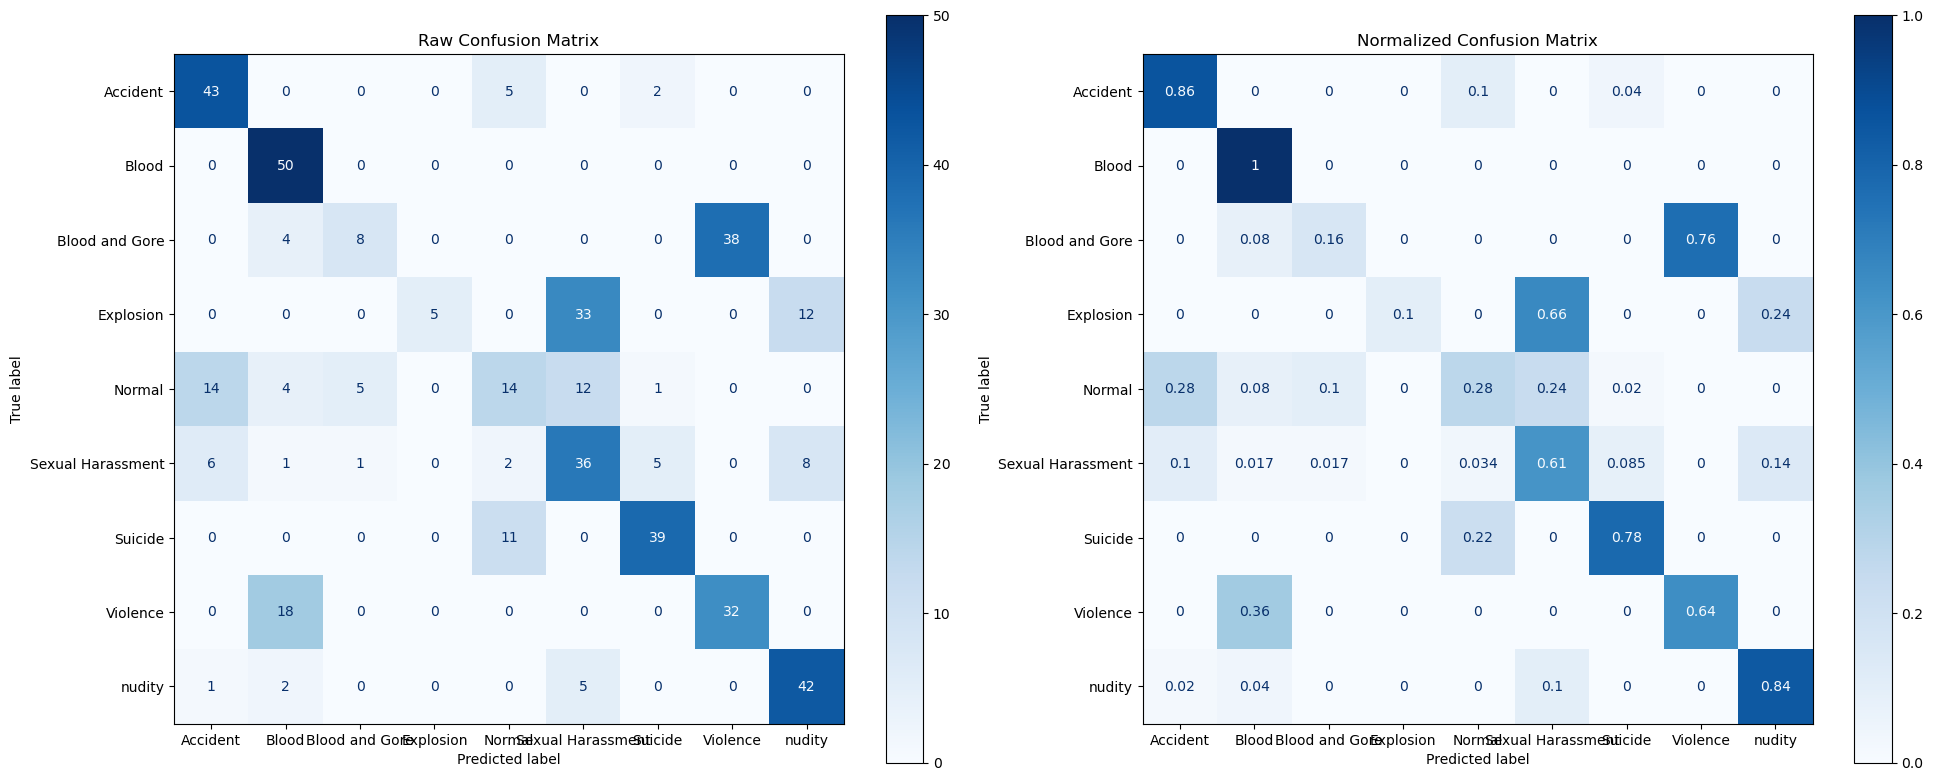


Per-class Analysis:
Accident: 0.860 accuracy (50 samples)
Blood: 1.000 accuracy (50 samples)
Blood and Gore: 0.160 accuracy (50 samples)
Explosion: 0.100 accuracy (50 samples)
Normal: 0.280 accuracy (50 samples)
Sexual Harassment: 0.610 accuracy (59 samples)
Suicide: 0.780 accuracy (50 samples)
Violence: 0.640 accuracy (50 samples)
nudity: 0.840 accuracy (50 samples)


In [18]:
loss, acc, precision, recall = model.evaluate(test_generator)
print(f"\nTest Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Advanced evaluation
advanced_evaluation(model, test_generator)

In [19]:
def predict_with_threshold(model, image_path, threshold=0):
    """
    Predict dengan confidence threshold untuk mengurangi false positives
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    
    prediction = model.predict(img_array)
    confidence = np.max(prediction)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    
    if confidence < threshold:
        predicted_class = "Uncertain - Low Confidence"
    
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    print(f"All probabilities: {dict(zip(class_names, prediction[0]))}")
    
    plt.imshow(img)
    plt.title(f"{predicted_class} (Confidence: {confidence:.3f})")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

print("\nModel training completed! Use predict_with_threshold() for better predictions.")


Model training completed! Use predict_with_threshold() for better predictions.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Class: Blood
Confidence: 0.9320
All probabilities: {'Accident': 0.00015361412, 'Blood': 0.93201005, 'Blood and Gore': 0.0023491106, 'Explosion': 0.0009334746, 'Normal': 0.0046417518, 'Sexual Harassment': 0.031085055, 'Suicide': 0.0006818686, 'Violence': 0.003039018, 'nudity': 0.02510601}


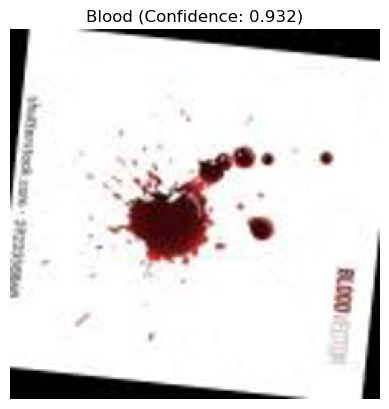

('Blood', 0.93201005)

In [20]:
predict_with_threshold(model, 'converted/test/Blood/0_w_bloodstains_82_jpg.rf.8a886252237fc4bc514e7493c5ddf111.jpg')